In [317]:
import tensorflow as tf
print(tf.__version__)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress info and warning messages
import tensorflow.keras as keras
import math
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

2.19.0


In [318]:
dataset_dir = '/Users/sophiacherkaoui/Downloads/living_room_dataset'

In [319]:
rentals = keras.utils.image_dataset_from_directory(dataset_dir, labels='inferred', class_names=["Deluxe", "Luxury", "Standard"], seed=1234)
dataset_size = len(rentals)

train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

train_ds = rentals.take(train_size)
test_ds = rentals.skip(train_size)

Found 85 files belonging to 3 classes.


In [320]:
# some useful lines if needed
"""
img_tensor, label = next(iter(rentals.unbatch()))
img_np = img_tensor.numpy()                   
print("shape:", img_np.shape, "dtype:", img_np.dtype)
print(img_np)                              
plt.imshow(img_np.astype("uint8"))                
plt.title(rentals.class_names[label])
plt.axis(False)
plt.show()
"""

'\nimg_tensor, label = next(iter(rentals.unbatch()))\nimg_np = img_tensor.numpy()                   \nprint("shape:", img_np.shape, "dtype:", img_np.dtype)\nprint(img_np)                              \nplt.imshow(img_np.astype("uint8"))                \nplt.title(rentals.class_names[label])\nplt.axis(False)\nplt.show()\n'

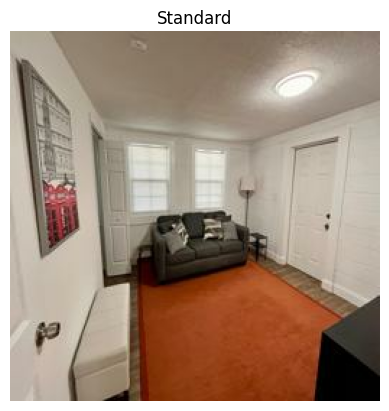

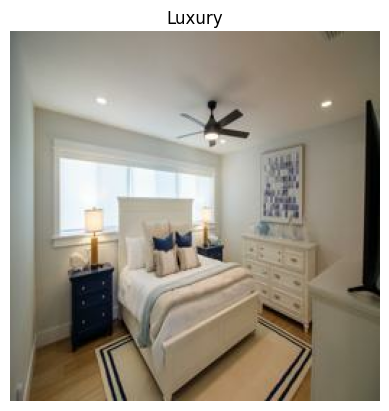

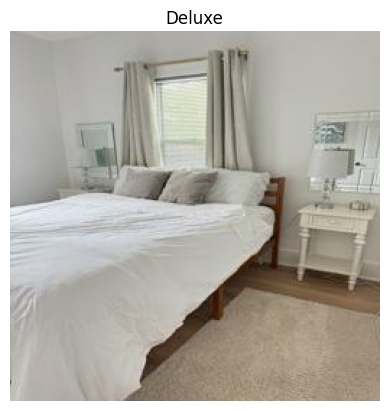

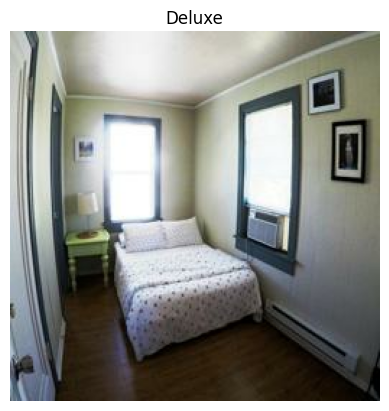

In [322]:
# prints four random examples from dataset
for i in range(1, 5):
    img_tensor, label = next(iter(rentals.unbatch()))
    img_np = img_tensor.numpy()
    plt.imshow(img_np.astype("uint8"))                
    plt.title(rentals.class_names[label])
    plt.axis(False)
    plt.show()

In [323]:
# print shape of one example
img_np.shape

(256, 256, 3)

In [324]:
# function to convert training and test datasets to numpy arrays. each item in train_ds, test_ds is a tuple in the form (image_batch, label_batch)
def to_numpy(dataset):
    images = []
    labels = []

    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())

    # merge all examples and labels into their respective sets
    X = np.concatenate(images, axis=0)
    y = np.concatenate(labels, axis=0)

    return X, y

In [325]:
# call dataset_to_numpy on training and test batches

X_train, y_train = to_numpy(train_ds)
X_test, y_test = to_numpy(test_ds)

In [326]:
# normalize pixel values to speed up model training and prevent outliers
X_train = X_train / 255.0
X_test = X_test / 255.0

# verify values were normalized (should be between 0 and 1)
X_train[0]
X_test[0]

array([[[0.7058824 , 0.65882355, 0.6039216 ],
        [0.7058824 , 0.65882355, 0.6039216 ],
        [0.7137255 , 0.6666667 , 0.6117647 ],
        ...,
        [0.6901961 , 0.68235296, 0.6313726 ],
        [0.6901961 , 0.68235296, 0.6313726 ],
        [0.6901961 , 0.68235296, 0.6313726 ]],

       [[0.7058824 , 0.65882355, 0.6039216 ],
        [0.7058824 , 0.65882355, 0.6039216 ],
        [0.70980394, 0.6627451 , 0.60784316],
        ...,
        [0.6901961 , 0.68235296, 0.6313726 ],
        [0.6901961 , 0.68235296, 0.6313726 ],
        [0.6862745 , 0.6784314 , 0.627451  ]],

       [[0.69411767, 0.65882355, 0.6       ],
        [0.69411767, 0.65882355, 0.6       ],
        [0.69411767, 0.65882355, 0.6       ],
        ...,
        [0.6901961 , 0.68235296, 0.6313726 ],
        [0.6862745 , 0.6784314 , 0.627451  ],
        [0.6862745 , 0.6784314 , 0.627451  ]],

       ...,

       [[0.70980394, 0.58431375, 0.39215687],
        [0.70980394, 0.58431375, 0.39215687],
        [0.7137255 , 0

In [309]:
# inspect training and test sets
print("X_train: " + str(X_train.shape))
print("X_test: " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test: " + str(y_test.shape))

X_train: (64, 256, 256, 3)
X_test: (21, 256, 256, 3)
y_train: (64,)
y_test: (21,)


In [327]:
# verify shape of one example -- should be (pixel height, pixel width, color channels)
# color channels = 3 since the images are RGB
X_train[0].shape

(256, 256, 3)

In [328]:
# building the model
cnn_model = keras.Sequential()

input_shape = X_train[0].shape
input_layer = keras.layers.InputLayer(input_shape)
cnn_model.add(input_layer)

conv_1 = keras.layers.Conv2D(16, 3)
batchNorm_1 = keras.layers.BatchNormalization()
ReLU_1 = keras.layers.ReLU()
cnn_model.add(conv_1)
cnn_model.add(batchNorm_1)
cnn_model.add(ReLU_1)

conv_2 = keras.layers.Conv2D(32, 3)
batchNorm_2 = keras.layers.BatchNormalization()
ReLU_2 = keras.layers.ReLU()
cnn_model.add(conv_2)
cnn_model.add(batchNorm_2)
cnn_model.add(ReLU_2)

pooling_layer = keras.layers.GlobalAveragePooling2D()
cnn_model.add(pooling_layer)

output_layer = keras.layers.Dense(units=5)
cnn_model.add(output_layer)

cnn_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 254, 254, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 254, 254, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 252, 252, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 252, 252, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 252, 252, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,445 (21.27 KB)

 Trainable params: 5,349 (20.89 KB)

 Non-trainable params: 96 (384.00 B)

In [329]:
sgd_optimizer = keras.optimizers.SGD(learning_rate=1e-4)

In [330]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [331]:
cnn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

In [332]:
num_epochs = 1 # Number of epochs

t0 = time.time() # start time

history = cnn_model.fit(X_train, y_train, epochs=num_epochs)

t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.2969 - loss: 1.5494
Elapsed time: 11.74s


In [333]:
loss, accuracy = cnn_model.evaluate(X_test, y_test)

print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.0952 - loss: 1.6016
Loss:  1.6016016006469727 Accuracy:  0.095238097012043
